# Домашнее задание 2
### Андреев Никита

In [122]:
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.optimize as opt
import scipy.sparse
import sklearn.datasets
from sklearn.model_selection import train_test_split

#### Определим функцию $\sigma$:

## $\sigma_w(x)=\frac{e^{w^tx}}{1+e^{w^tx}}=\frac{1}{1+e^{-w^tx}}$

Тогда
$1-\sigma_w(x)=1-\frac{1}{1+e^{-w^tx}}=\frac{1}{1+e^{w^tx}}=\sigma_w(-x)$

#### Функция, которую необходимо минимизировать:
## $f(w)=-\frac{1}{N}\sum\limits_1^n\log(\sigma_w(y_i x_i))$, $y_i =\pm 1$

#### Посчитаем производные:

### $\nabla\sigma_w(x)=\frac{e^{-w^tx}}{(1+e^{-w^tx})^2}x = \sigma_w(x) \sigma_w(-x)x$

### $\nabla f(w) = -\frac{1}{N}\sum\limits_1^n\sigma_w(-y_i x_i)y_i x_i$

### $\nabla^2 f(w) = \frac{1}{N}\sum\limits_1^n\sigma_w(y_i x_i)\sigma_w(-y_i x_i)x_i x_i^t=
\frac{1}{N}\sum\limits_1^n\sigma_w(x_i)\sigma_w(-x_i)x_i x_i^t$

Матрица $X$ для датасета a1a разрежена, поэтому я попытался определить функции так, чтобы это учесть:

In [155]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def oracle(w, X, labels, outers=None, order=0):
    Xw = X.dot(w)
    sigmoids = [sigmoid(l * xw) for xw, l in zip(Xw, labels)]
    f = -1 / X.shape[0] * np.sum([np.log(s) for s in sigmoids])

    if order == 0:
        return f

    grad_coeffs = np.array([l * (1 - s) for s, l in zip(sigmoids, labels)])
    X1 = X.multiply(grad_coeffs.reshape(-1, 1))
    g = -1 / X.shape[0] * np.array(X1.sum(axis=0)).reshape(X.shape[1])

    if order == 1:
        return f, g, 0
        # 0 чтобы order 1 и 2 оба возвращали 3 значения

    hess_coeffs = np.array([s * (1 - s) for s in sigmoids])
    if outers is None:
        h = 1 / X.shape[0] * np.sum([np.outer(x, x) * hess_coeffs[i] for i, x in enumerate(X.todense())], axis=0)
    else:
        outers1 = outers.multiply(grad_coeffs.reshape(-1, 1))
        h = 1 / X.shape[0] * np.array(outers1.sum(axis=0)).reshape((X.shape[1], X.shape[1]))

    if order == 2:
        return f, g, h

    
def function(w, X, labels):
    return oracle(w, X, labels)


def gradient(w, X, labels):
    return oracle(w, X, labels, order=1)[1]


def hessian(w, X, labels):
    return oracle(w, X, labels, order=2)[2]

#### Тесты для проверки правильности вычисления производных:

In [156]:
#численное дифференцирование
def der(fun, point, epsilon=np.sqrt(sys.float_info.epsilon)):
    return (fun(point + epsilon) - fun(point)) / epsilon

#считает среднюю относительную погрешность по всем кординатным осям в рандомной точке из [-R, R]^dim
def check_gradient(fun, grad, R, dim, args=(), diff_eps=np.sqrt(sys.float_info.epsilon)):
    w = np.random.random(dim)
    w = (2 * w - 1) * R
    dw = np.eye(dim)
    g = grad(w, *args)
    norm = np.dot(g, g)
    difs = [np.abs((np.dot(g, dw_i) - der(lambda t: fun(w + t * dw_i, *args), 0, diff_eps))) for dw_i in dw]
    return np.average(difs) / norm

#считает среднюю относительную погрешность по всем парам кординатных осей в рандомной точке из [-R, R]^dim
def check_hessian(grad, hess, R, dim, args=(), diff_eps=np.sqrt(sys.float_info.epsilon)):
    w = np.random.random(dim)
    w = (2 * w - 1) * R
    dw = np.eye(dim)
    h = hess(w, *args)
    norm = np.dot(h.flatten(), h.flatten())
    difs = [np.abs(np.dot(dw1, np.dot(h, dw2)) - der(lambda t: np.dot(grad(w + t * dw1, *args), dw2), 0, diff_eps)) for dw1 in dw
            for dw2 in dw]
    return np.average(difs) / norm


### В качестве данных впредь будем использовать три датасета:

a1a:

In [157]:
a1a = sklearn.datasets.load_svmlight_file('../data/a1a.txt')
X = a1a[0]
dummy = scipy.sparse.csr_matrix([[1] for i in range(X.shape[0])])
X_a1a = scipy.sparse.hstack([X, dummy])
labels_a1a = a1a[1]

breast cancer: (координаты нормированы от -1 до 1)

In [158]:
breast_cancer = sklearn.datasets.load_svmlight_file('../data/breast-cancer_scale.txt')
X = breast_cancer[0]
dummy = scipy.sparse.csr_matrix([[1] for i in range(X.shape[0])])
X_cancer = scipy.sparse.hstack([X, dummy])
labels_cancer = breast_cancer[1]-3

Случайный сгенерированный:

In [159]:
def random_dataset(alpha, beta):
    xs = np.random.normal(size=(1000, alpha.shape[0]))
    labels = np.array([np.sign(np.dot(alpha, x) + beta) for x in xs])
    return xs, labels


In [160]:
alpha = 2 * np.random.random(10) - 1
beta = 2 * np.random.random() - 1
X, labels_rand = random_dataset(alpha, beta)
dummy = scipy.sparse.csr_matrix([[1] for i in range(X.shape[0])])
X_rand = scipy.sparse.hstack([X, dummy])

Посмотрим, правильно ли посчитаны градиент и гессиан:

In [161]:
print('погрешность градиента =', check_gradient(function, gradient, 1, X_a1a.shape[1], args=[X_a1a, labels_a1a]))
print('погрешность гессиана =', check_hessian(gradient, hessian, 1, X_a1a.shape[1], args=[X_a1a, labels_a1a]))
#долго - большая размерность

погрешность градиента = 5.298418049917885e-08
погрешность гессиана = 1.2903098556083317e-09


In [162]:
print('погрешность градиента =', check_gradient(function, gradient, 1, X_cancer.shape[1], args=[X_cancer, labels_cancer]))
print('погрешность гессиана =', check_hessian(gradient, hessian, 1, X_cancer.shape[1], args=[X_cancer, labels_cancer]))

погрешность градиента = 7.0766541832041895e-09
погрешность гессиана = 3.925269305383208e-08


In [163]:
print('погрешность градиента =', check_gradient(function, gradient, 1, X_rand.shape[1], args=[X_rand, labels_rand]))
print('погрешность гессиана =', check_hessian(gradient, hessian, 1, X_rand.shape[1], args=[X_rand, labels_rand]))

погрешность градиента = 3.022358180621045e-08
погрешность гессиана = 4.683710513620818e-08


Результаты говорят о том, что всё правильно

#### Метод золотого сечения:

In [1]:
#на заданном интервале: возвращает точку минимума и число вызовов функции
def golden_search_bounded(fun, a0, b0, eps=0.0001, args=()):
    ratio = (1 + 5 ** 0.5) / 2

    def step(a, b, c, fc, onumber):
        if b - a < eps:
            return a, fun(a, *args), onumber + 1
        else:
            d = a + b - c
            fd = fun(d)
            if c > d:
                c, d = d, c
                fc, fd = fd, fc
            if fc < fd:
                return step(a, d, c, fc, onumber + 1)
            else:
                return step(c, b, d, fd, onumber + 1)

    c0 = a0 + (b0 - a0) / ratio
    solution = step(a0, b0, c0, fun(c0, *args), 0)
    return solution[0], solution[2]


#общий случай используя bracket
def golden_search(fun, eps=0.0001, args=()):
    a, _, b, _, _, _, onumber = opt.bracket(fun, args=args)
    if b < a:
        a, b = b, a
    gsb = golden_search_bounded(fun, a, b, eps=eps, args=args)
    return gsb[0], gsb[1] + onumber


Метод для построения графиков:

In [17]:
def graph(x, y, x_l=None, y_l=None, title=None):
    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.set(xlabel=x_l, ylabel=y_l, title=title)
    ax.grid()
    plt.show()
    

Сгенерируем полиномы 2, 3 и 5 степени и построим графики чтобы понять с каких интервалов начинать поиск минимума:

-0.95717287 + -0.75630972x + 0.72343828x ^ 2


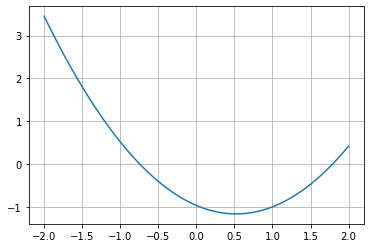

0.97490814 + 0.80688161x + 0.05165432x ^ 2 + -0.52669906x ^ 3


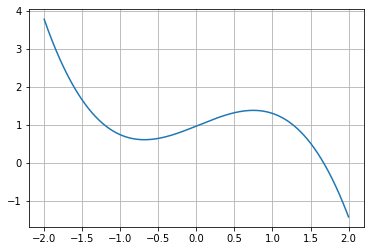

0.74540317 + -0.50950527x + 0.96825081x ^ 2 + -0.0243777x ^ 3 +-0.33768442x ^ 4 + 0.13532899x ^ 5


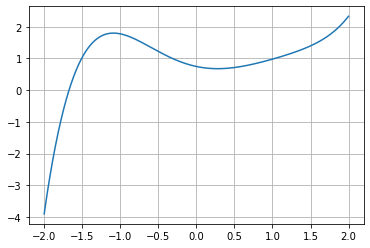

In [153]:
c2, c3, c5 = [-0.95717287, -0.75630972, 0.72343828], [0.97490814, 0.80688161, 0.05165432, -0.52669906], [0.74540317,
                                                                                                         -0.50950527,
                                                                                                         0.96825081,
                                                                                                         -0.0243777,
                                                                                                         -0.33768442,
                                                                                                         0.13532899]

def pol2(x):
    return c2[0] + c2[1] * x + c2[2] * x ** 2


def pol3(x):
    return c3[0] + c3[1] * x + c3[2] * x ** 2 + c3[3] * x ** 3


def pol5(x):
    return c5[0] + c5[1] * x + c5[2] * x ** 2 + c5[3] * x ** 3 + c5[4] * x ** 4 + c5[5] * x ** 5

xs = np.arange(-2, 2, 0.001)
print(str(c2[0]) + ' + ' + str(c2[1]) + 'x + ' + str(c2[2]) + 'x ^ 2')
graph(xs, [pol2(x) for x in xs])

print(str(c3[0]) + ' + ' + str(c3[1]) + 'x + ' + str(c3[2]) + 'x ^ 2 + ' + str(c3[3]) + 'x ^ 3')
graph(xs, [pol3(x) for x in xs])

print(str(c5[0]) + ' + ' + str(c5[1]) + 'x + ' + str(c5[2]) + 'x ^ 2 + ' + str(c5[3]) + 'x ^ 3 +' + str(
          c5[4]) + 'x ^ 4 + ' + str(c5[5]) + 'x ^ 5')
graph(xs, [pol5(x) for x in xs])

In [150]:
x, fev = golden_search_bounded(pol2, -0.5, 1.5, eps=0.0000001)

opt1 = opt.minimize_scalar(pol2, bracket=[-0.5, 0, 1.5], method='brent')
x1, fev1 = opt1['x'], opt1['nfev']

print('x golden =', x, ', nfev =', fev)
print('x brent =', x1, ', nfev =', fev1)
print('pol2(x golden) - pol2(x brent) =', pol2(x) - pol2(x1))

x golden = 0.5227188789917765 , nfev = 36
x brent = 0.5227188895728239 , nfev = 9
pol2(x golden) - pol2(x brent) = 4.440892098500626e-16


In [151]:
x, fev = golden_search_bounded(pol3, -1.5, 0, eps=0.000001)

opt1 = opt.minimize_scalar(pol3, bracket=[-1.5, -1, 0], method='brent')
x1, fev1 = opt1['x'], opt1['nfev']

print('x golden =', x, ', nfev =', fev)
print('x brent =', x1, ', nfev =', fev1)
print('pol3(x golden) - pol3(x brent) =', pol3(x) - pol3(x1))

x golden = -0.6826571097902062 , nfev = 31
x brent = -0.6826567604746772 , nfev = 14
pol3(x golden) - pol3(x brent) = 1.4444001550373287e-13


In [152]:
x, fev = golden_search_bounded(pol5, -0.5, 1.0, eps=0.000001)

opt1 = opt.minimize_scalar(pol5, bracket=[-0.5, 0, 1], method='brent')
x1, fev1 = opt1['x'], opt1['nfev']

print('x golden =', x, ', nfev =', fev)
print('x brent =', x1, ', nfev =', fev1)
print('pol5(x golden) - pol5(x brent) =', pol5(x) - pol5(x1))

x golden = 0.2790903681196425 , nfev = 31
x brent = 0.2790908876932606 , nfev = 16
pol5(x golden) - pol5(x brent) = 2.2226664952995634e-13


#### Поиск шага с использованием условия Армихо:

In [154]:
def armiho(fun, c=0.5, x0=1, df0=None):
    x = x0
    f0 = fun(0)
    oracle = 1

    if df0 is None:
        df0 = der(fun, 0)
    while fun(x) > f0 + c * x * df0:
        x /= 2
        oracle += 1
    oracle += 1

    return x, oracle


#### Поиск шага с помощью оценки константы Липшица (схема Нестерова, насколько я понял):

In [ ]:
def nester(fun, f0, d, L0=1):
    L = L0
    oracle = 0

    while fun(1 / L) > f0 - 1 / (2 * L) * np.dot(d, d):
        L *= 2
        oracle += 1
    oracle += 1

    return L, oracle


Чтобы решить систему $Hx = y$, где $H$ - положительно определённая матрица, будем использовать разложение Холецкого:

In [ ]:
def solve(G, d):
    L = np.linalg.cholesky(G)
    Ltx = scipy.linalg.solve_triangular(L, d, lower=True)
    return scipy.linalg.solve_triangular(np.transpose(L), Ltx, lower=False)


## Градиентный спуск и метод Ньютона:

Разница только в выборе направления - поэтому всё в одном методе

Параметры:

1. oracle - оракул
2. start - начальная точка
3. method - 'gradient descent' или 'newton'
4. one_dim_search - способ выбора шага:
    'unit step',
    'brent',
    'golden',
    'armiho',
    'nester',
    'wolf'
5. args - аргументы для оракула (X, labels)
6. search_kwargs - аргументы для метода одномерной оптимизации
7. epsilon - для условия остановки


Возвращает:

1. x - результат
2. iterations - range от 0 до количества итераций
3. oracles - массив чисел вызовов оракула с начала до текущего шага
4. times - массив времён от начала вычисления до текущего шага
5. values - массив значений функции
6. grad_ratios - массив отношений $||\nabla f(w_k)||^2/||\nabla f(w_0)||^2$

In [ ]:
def optimization_task(oracle, start, method='gradient descent', one_dim_search=None, args=(),
                      search_kwargs=dict([]), epsilon=0.0001, true_min=0):
    iterations, oracles, times, accuracies, grad_ratios = [], [], [], [], []
    start_time, k, onumber = time.time(), 0, 0
    x = start

    if method == 'gradient descent':
        ord = 1
        if one_dim_search is None:
            one_dim_search = 'brent'
    elif method == 'newton':
        ord = 2
        if one_dim_search is None:
            one_dim_search = 'unit step'

    f0, g0, _ = oracle(x, *args, order=1)
    onumber += 1

    if one_dim_search == 'nester':
        L, L0 = 2, 0
        if 'L0' in search_kwargs.keys():
            L0 = 2 * search_kwargs['L0']
            L = L0

    while True:
        fk, gk, hk = oracle(x, *args, order=ord)
        if method == 'gradient descent':
            d = -gk
        elif method == 'newton':
            d = -solve(hk, gk)
        onumber += 1
        ratio = np.dot(gk, gk) / np.dot(g0, g0)
        iterations.append(k)
        k += 1
        oracles.append(onumber)
        times.append(time.time() - start_time)
        accuracies.append(fk - true_min)
        grad_ratios.append(ratio)

        if ratio <= epsilon:
            break

        fun = lambda alpha: oracle(x + d * alpha, *args)

        if one_dim_search == 'unit step':
            alpha = 1
        elif one_dim_search == 'golden':
            alpha, oracle_counter = golden_search(fun, **search_kwargs)
            onumber += oracle_counter
        elif one_dim_search == 'brent':
            solution = opt.minimize_scalar(fun)
            alpha = solution['x']
            onumber += solution['nfev']
        elif one_dim_search == 'armiho':
            alpha, oracle_counter = armiho(fun, **search_kwargs, df0=np.dot(gk, d))
            onumber += oracle_counter
        elif one_dim_search == 'wolf':
            f_for_wolf = lambda z: oracle(z, *args)
            g_for_wolf = lambda z: oracle(z, *args, order=1)[1]
            solution = opt.line_search(f_for_wolf, g_for_wolf, x, d, **search_kwargs, gfk=gk, old_fval=fk)
            alpha = solution[0]
            #wolf не принимает оракул, вычисляющий одновременно функцию и градиент, хотя мог бы,
            #так что я учёл только вызовы функции
            onumber += solution[1]
        elif one_dim_search == 'nester':
            L, oracle_counter = nester(fun, fk, gk, L0=max(L / 2, L0))
            alpha = 1 / L
            onumber += oracle_counter

        x = x + d * alpha

    return x, iterations, oracles, times, accuracies, grad_ratios
